In [3]:
import torch
import torch.nn.functional as F

In [180]:
class LinearD:
    
    def __init__(self,in_features,out_features,bias = True):
        
        self.weights = torch.randn((in_features,out_features))/(in_features**0.5) # gain 1 for Linear layer, Kaiming initialization
        
        self.bias = torch.randn((1,out_features)) if bias else None
        
    def __call__(self,x):
        
        self.out = x @ self.weights 
        
        if self.bias is not None:
            self.out += self.bias
        
        return self.out
    
    def parameters(self):
        
        return [self.weights] + ([self.bias] if self.bias is not None else [])


In [181]:
class BatchNormD:
    
    def __init__(self, dim, momentum=0.01):
        
        self.eps = 1e-5
        
        self.dim = dim
        
        self.momentum = momentum
        
        self.gamma = torch.ones((dim))
        
        self.beta = torch.zeros((dim))
        
        self.training = True # To signify whether th model is in training or not so as to use cached mean and var or not
        
        #caching the mean and variance
        
        self.cache_mean = torch.zeros(dim)
        
        self.cache_var = torch.ones(dim)
        
    def __call__(self,x):
        
        tup = ()
        if self.training:
            if x.ndim == 2:
                tup = (0)
            if x.ndim == 3:
                tup = (0,1)
            xmean = x.mean(tup, keepdim = True)
            xvar = x.var(tup, keepdim = True)
            
            
            #Updating the cache values
            
            self.cache_mean = (1-self.momentum)*self.cache_mean + self.momentum * xmean
            
            self.cache_var = (1-self.momentum)*self.cache_var + self.momentum * xvar
        else:
            xmean = self.cache_mean
                    
            xvar = self.cache_var
                    
        self.out = self.gamma * (x - xmean)/torch.sqrt(xvar + self.eps) + self.beta
            
        return self.out
    
    def parameters(self):
        
        return [self.gamma,self.beta]
        

In [182]:
class EmbeddingD:
    
    def __init__(self, dim1, dim2):
        
        self.emb = torch.randn((dim1,dim2))
    
    def __call__(self, x):
        
        self.out = self.emb[x]
        
        return self.out
    
    def parameters(self):
        
        return [self.emb]

In [183]:
class TanhD:
     
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [184]:
class SequentialD:
    
    def __init__(self, layers):
        
        self.layers = layers
    
    def __call__(self, x):
        
        for layer in self.layers:
            
            x = layer(x)
            
        self.out = x
        
        return self.out
    
    def parameters(self):
        
        return [p for layer in self.layers for p in layer.parameters()]


In [185]:
class FlattenD:
    
    def __init__(self, n):
        self.n = n
    
    def __call__(self,x):
        
        a,b,c = x.shape
        
        x = x.view(a, b//self.n, c*self.n)
        
        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        
        return self.out
    def parameters(self):
        
        return []

In [186]:
import random

words = open('/Users/vijayshekar/Desktop/names.txt','r').read().splitlines()

stoi = {x:y+1 for y,x in enumerate(sorted(list(set(''.join(words)))))}

stoi['.'] = 0

len(stoi)

itos = {y+1:x for y,x in enumerate(sorted(list(set(''.join(words)))))}
itos[0] = '.'

block = 8

def build_dataset(words):
  X = []
  Y = []

  for w in words:
    context = [0] * block
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y



random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     
Xdev, Ydev = build_dataset(words[n1:n2])   
Xte,  Yte  = build_dataset(words[n2:])     

In [187]:
Xtr.shape

torch.Size([182532, 8])

In [188]:
dim1 = len(stoi)
dim2 = 24
n_hidden = 128

model = SequentialD([
    EmbeddingD(dim1,dim2),
    FlattenD(2),LinearD(2*dim2, n_hidden,bias = False),BatchNormD(n_hidden),TanhD(),## Not using bias in Linear layer 
    FlattenD(2),LinearD(2*n_hidden, n_hidden,bias = False),BatchNormD(n_hidden),TanhD(),## because we add it through the
    FlattenD(2),LinearD(2*n_hidden, n_hidden,bias = False),BatchNormD(n_hidden),TanhD(),## BatchNormD layer
    LinearD(n_hidden,dim1)
])
with torch.no_grad():
    model.layers[-1].weights *= 0.1 
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
  p.requires_grad = True

76579


In [189]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  idx = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[idx], Ytr[idx] 

  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  for p in parameters:
    p.grad = None
  loss.backward()
  
  lr = 0.1 if i < 150000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0: 
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.7938
  10000/ 200000: 2.0183
  20000/ 200000: 2.3336
  30000/ 200000: 2.4301
  40000/ 200000: 2.1942
  50000/ 200000: 1.8589
  60000/ 200000: 1.6826
  70000/ 200000: 1.6467
  80000/ 200000: 1.9898
  90000/ 200000: 2.1608
 100000/ 200000: 2.1964
 110000/ 200000: 1.9948
 120000/ 200000: 1.7495
 130000/ 200000: 2.1519
 140000/ 200000: 2.3536
 150000/ 200000: 2.0677
 160000/ 200000: 2.1820
 170000/ 200000: 1.5564
 180000/ 200000: 2.0150
 190000/ 200000: 1.8826


In [191]:
import matplotlib.pyplot as plt

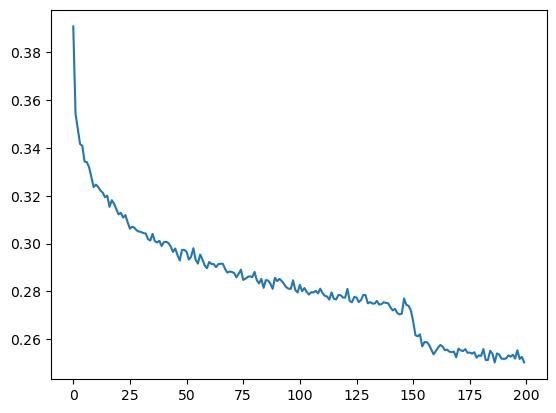

In [192]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [193]:
for layer in model.layers:
    layer.training = False

In [197]:
for i in range(20):
    context = [0]*8
    word = ""
    while True:
        x = model(torch.tensor([context]))
        x = F.softmax(x,dim = 1)
        idx = torch.multinomial(x, num_samples = 1).item()
        if idx==0:
            print(word)
            break
        word = word + itos[idx]
        context = context[1:] + [idx]
        
            

vedris
storm
marlene
mitrett
quavion
baki
limitty
maddison
mirah
nori
mahu
delana
aubreelynn
jakair
divine
karlaya
zamarie
jacly
shanyah
vienne
